In [ ]:
 ! jupyter nbconvert --to html ///content/Copy_of_Resnet_CIFAR10.ipynb

[NbConvertApp] Converting notebook ///content/Copy_of_Resnet_CIFAR10.ipynb to html
[NbConvertApp] Writing 1871917 bytes to /content/Copy_of_Resnet_CIFAR10.html


In [1]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU device found:', tf.test.gpu_device_name())
else:

    print("No GPU found")

No GPU found


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator



# Case 1. with Feature Extraction Only

## Data

In [3]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
# Further split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

input preprocessing: https://keras.io/api/applications/resnet/#resnet50-function

In [5]:
print("Training set shape:", X_train.shape, Y_train.shape)
print("Vaidation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (42500, 32, 32, 3) (42500, 1)
Vaidation set shape: (7500, 32, 32, 3) (7500, 1)
Test set shape: (10000, 32, 32, 3) (10000, 1)


In [6]:
num_lasses=10
def preprocess_data (X,Y):
  x=keras.applications.resnet.preprocess_input(X)
  y= keras.utils.to_categorical(Y,num_lasses)
  return x, y


In [7]:
X_train, Y_train= preprocess_data(X_train, Y_train)
X_val, Y_val= preprocess_data(X_val, Y_val)
X_test, Y_test= preprocess_data(X_test, Y_test)

In [8]:
Y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
print("Training set shape:", X_train.shape, Y_train.shape)
print("Vaidation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (42500, 32, 32, 3) (42500, 10)
Vaidation set shape: (7500, 32, 32, 3) (7500, 10)
Test set shape: (10000, 32, 32, 3) (10000, 10)


## Transfer Learning

### base model

In [10]:
# base model
ResNet_base = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
# freeze all layers
ResNet_base.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
ResNet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

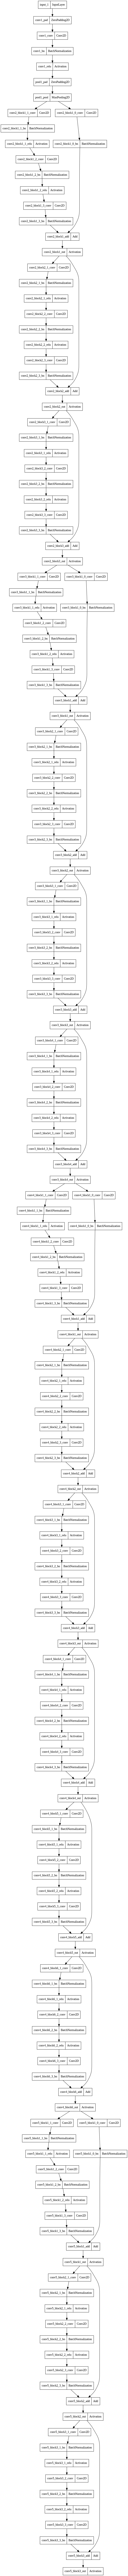

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(ResNet_base, to_file='model.png')

In [13]:
for i, layer in enumerate (ResNet_base.layers):
  print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [14]:
len(ResNet_base.layers)

175

# Top layers&Model

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
input = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(inputs)
x=ResNet_base(input,training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
#check if the base model is freezed:
ResNet_base.trainable=False

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])


In [ ]:
tf.random.set_seed(42)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val), batch_size=128, epochs=10, verbose=1
)

Epoch 1/10
333/333 [==============================] - 139s 409ms/step - loss: 0.5527 - accuracy: 0.8105 - val_loss: 0.3218 - val_accuracy: 0.8896
Epoch 2/10
333/333 [==============================] - 135s 405ms/step - loss: 0.3419 - accuracy: 0.8804 - val_loss: 0.2790 - val_accuracy: 0.9013
Epoch 3/10
333/333 [==============================] - 135s 405ms/step - loss: 0.3100 - accuracy: 0.8919 - val_loss: 0.2712 - val_accuracy: 0.9057
Epoch 4/10
333/333 [==============================] - 135s 405ms/step - loss: 0.2890 - accuracy: 0.8975 - val_loss: 0.2837 - val_accuracy: 0.9027
Epoch 5/10
333/333 [==============================] - 135s 405ms/step - loss: 0.2820 - accuracy: 0.9013 - val_loss: 0.2715 - val_accuracy: 0.9084
Epoch 6/10
333/333 [==============================] - 135s 405ms/step - loss: 0.2749 - accuracy: 0.9026 - val_loss: 0.2636 - val_accuracy: 0.9111
Epoch 7/10
333/333 [==============================] - 135s 406ms/step - loss: 0.2687 - accuracy: 0.9056 - val_loss: 0.2794 -

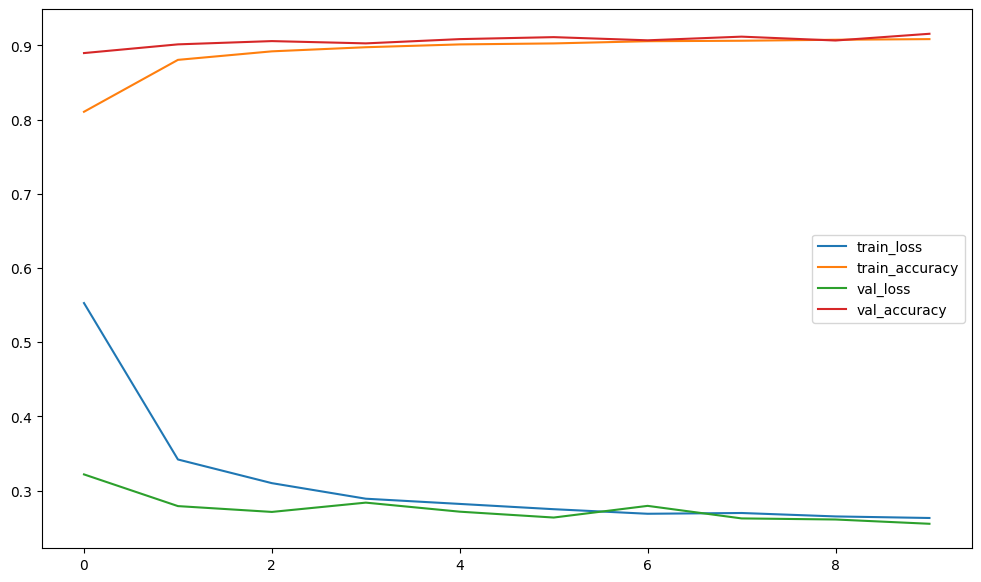

In [ ]:
fig, ax =  plt.subplots(figsize=(12,7))
ax.plot(history.history["loss"],label="train_loss")
ax.plot(history.history["accuracy"],label="train_accuracy")
ax.plot(history.history["val_loss"],label = "val_loss")
ax.plot(history.history["val_accuracy"],label = 'val_accuracy')
ax.legend()

In [ ]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 30s 95ms/step - loss: 0.2748 - accuracy: 0.9086


[0.2748320698738098, 0.9085999727249146]

# Case 2: with fine tuning

###base model

In [7]:
ResNet_base = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

94765736/94765736 [==============================] - 0s 0us/step


###Data

In [11]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()
# Further split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)
num_lasses=10
def preprocess_data (X,Y):
  x=keras.applications.resnet.preprocess_input(X)
  y= keras.utils.to_categorical(Y,num_lasses)
  return x, y
X_train, Y_train= preprocess_data(X_train, Y_train)
X_val, Y_val= preprocess_data(X_val, Y_val)
X_test, Y_test= preprocess_data(X_test, Y_test)


## Data Augmentation

In [12]:
tf.random.set_seed(42)
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)


# Flow the training data through the data generator
train_generator = datagen.flow(X_train, Y_train, batch_size=128)




###Model

In [13]:
inputs = tf.keras.Input(shape=(32, 32, 3))
input = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(inputs)
x=ResNet_base(input,training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


###To make the last 10 layers trainable

In [14]:
# Number of layers from the end to make trainable
num_train_layers=10
num_layers_untrain=len(ResNet_base.layers)-num_train_layers
for layer in ResNet_base.layers[:num_layers_untrain]:
  layer.trainable = False
for layer in ResNet_base.layers[num_layers_untrain:]:
  layer.trainable = True

In [15]:
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=["accuracy"])



In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Set a seed for reproducibility
tf.random.set_seed(42)

# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Training the model with Early Stopping
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=(X_val, Y_val),
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]  # Include the Early Stopping callback
)

Epoch 1/150
333/333 [==============================] - 192s 528ms/step - loss: 1.4933 - accuracy: 0.5129 - val_loss: 0.4770 - val_accuracy: 0.8343
Epoch 2/150
333/333 [==============================] - 175s 525ms/step - loss: 0.6729 - accuracy: 0.7734 - val_loss: 0.3727 - val_accuracy: 0.8691
Epoch 3/150
333/333 [==============================] - 155s 466ms/step - loss: 0.5491 - accuracy: 0.8104 - val_loss: 0.3272 - val_accuracy: 0.8843
Epoch 4/150
333/333 [==============================] - 174s 524ms/step - loss: 0.4804 - accuracy: 0.8345 - val_loss: 0.3134 - val_accuracy: 0.8911
Epoch 5/150
333/333 [==============================] - 175s 524ms/step - loss: 0.4424 - accuracy: 0.8473 - val_loss: 0.2924 - val_accuracy: 0.8983
Epoch 6/150
333/333 [==============================] - 174s 524ms/step - loss: 0.4081 - accuracy: 0.8601 - val_loss: 0.2758 - val_accuracy: 0.9023
Epoch 7/150
333/333 [==============================] - 174s 524ms/step - loss: 0.3815 - accuracy: 0.8662 - val_loss: 0

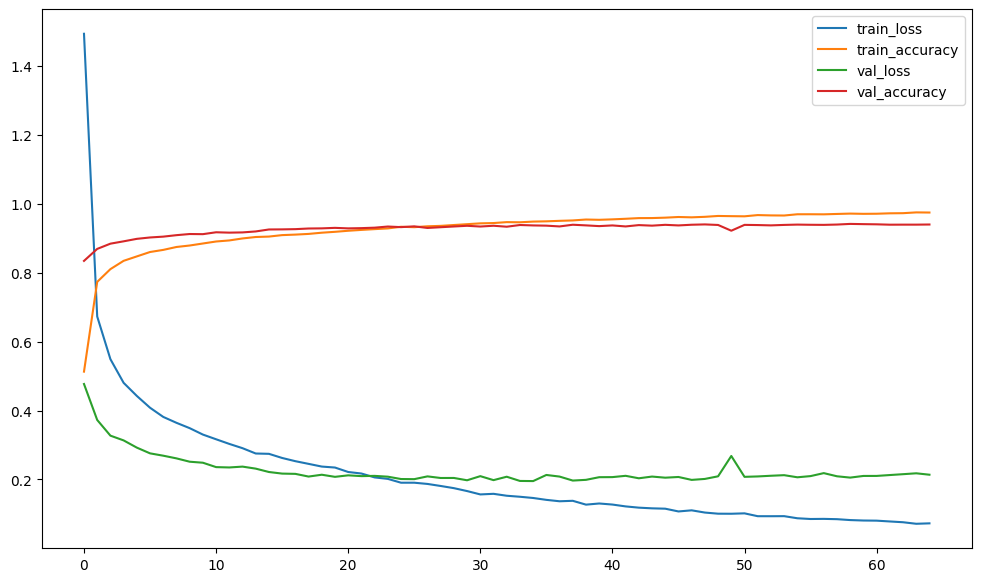

In [17]:
fig, ax =  plt.subplots(figsize=(12,7))
ax.plot(history.history["loss"],label="train_loss")
ax.plot(history.history["accuracy"],label="train_accuracy")
ax.plot(history.history["val_loss"],label = "val_loss")
ax.plot(history.history["val_accuracy"],label = 'val_accuracy')
ax.legend()